# Student Admission

In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=3)
import tensorflow as tf
from matplotlib import pyplot as plt
from yapf.yapflib.yapf_api import FormatCode
from pprint import pformat
def pprint(x):
    print(FormatCode(pformat(x))[0])
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
data = pd.read_csv('https://stats.idre.ucla.edu/stat/data/binary.csv')

In [2]:
one_hot_data = pd.concat([data, pd.get_dummies(data['rank'], prefix='rank')], axis=1)
one_hot_data = pd.concat([one_hot_data, pd.get_dummies(data['admit'], prefix='admit')], axis=1)

# Drop the previous rank column
data = one_hot_data.drop('rank', axis=1)
data = one_hot_data.drop('admit', axis=1)
print(data.shape)

(400, 9)


In [3]:
X = data.iloc[:,[0,1,2,3,4,5,6]]
y = data.iloc[:,[7,8]]

X = minmax_scale(X, feature_range=(0, 1))
X

array([[0.276, 0.776, 0.667, ..., 0.   , 1.   , 0.   ],
       [0.759, 0.81 , 0.667, ..., 0.   , 1.   , 0.   ],
       [1.   , 1.   , 0.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.414, 0.213, 0.333, ..., 1.   , 0.   , 0.   ],
       [0.828, 0.799, 0.333, ..., 1.   , 0.   , 0.   ],
       [0.655, 0.937, 0.667, ..., 0.   , 1.   , 0.   ]])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
X_train.shape, y_train.shape
X_train_batches, y_train_batches = np.split(X_train,20),np.split(y_train,20)

In [5]:
n_features = X_train.shape[1]
n_labels = y_train.shape[1]

features = tf.placeholder(tf.float32, [None, n_features])
labels = tf.placeholder(tf.float32, [None, n_labels])

w = [
    tf.Variable(tf.random_normal((n_features, 8), stddev=(1/tf.sqrt(float(n_features)))), name='Weights_layer_0'),
    tf.Variable(tf.random_normal((8, 4), stddev=(1/tf.sqrt(float(8)))), name='Weights_layer_1'),
    tf.Variable(tf.random_normal((4, n_labels), stddev=(1/tf.sqrt(float(4)))), name='Weights_layer_2'),
]

n_layers = len(w)
b = [
    tf.Variable(tf.random_normal((8,), stddev=0.01), name='Bias_layer_0'),
    tf.Variable(tf.random_normal((4,), stddev=0.01), name='Bias_layer_1'),
    tf.Variable(tf.random_normal((n_labels,), stddev=0.01), name='Bias_layer_2'),
]

In [6]:
def neural_network(input, weights, biases):
    for i in range(n_layers-1):
        layer = tf.add(tf.matmul(input if i==0 else layer, weights[i]),biases[i])
        layer = tf.nn.relu(layer)
        # layer = tf.nn.dropout(layer, keep_prob=0.6)
    out_layer = tf.add(tf.matmul(layer, weights[-1]),biases[-1])
    return out_layer

In [7]:
loss_ = []
res = []
prediction = neural_network(features, w, b)
# loss = tf.reduce_mean(-tf.reduce_sum(labels*tf.log(prediction), reduction_indices=1))
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=prediction, labels=labels))
optim = tf.train.AdagradOptimizer(0.05).minimize(loss)
# correct_prediction = tf.equal(tf.round(prediction), labels)
correct_prediction = tf.equal(tf.argmax(tf.sigmoid(prediction), 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
with tf.device('/dml:0'):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(50):
            for m,n in zip(X_train_batches, y_train_batches):
                _, l = sess.run([optim, loss],feed_dict={features: m, labels: n})
            loss_.append(l)
                # pprint(sess.run(w))
                # pprint(sess.run(b))

            acc = sess.run([accuracy], feed_dict={features: X_train, labels: y_train})
            print(i, acc)
        test_accuracy = sess.run(accuracy,feed_dict={features: X_test, labels: y_test})
        print(test_accuracy)
        res = sess.run(tf.sigmoid(prediction),feed_dict={features: X})

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
0 [0.7]
1 [0.7]
2 [0.7]
3 [0.7]
4 [0.7]
5 [0.7]
6 [0.7]
7 [0.7]
8 [0.7]
9 [0.7]
10 [0.7]
11 [0.7]
12 [0.7]
13 [0.7]
14 [0.7]
15 [0.7]
16 [0.7]
17 [0.7]
18 [0.7]
19 [0.7]
20 [0.7]
21 [0.7]
22 [0.7]
23 [0.7]
24 [0.7]
25 [0.7]
26 [0.7]
27 [0.7]
28 [0.7]
29 [0.70625]
30 [0.70625]
31 [0.7]
32 [0.70625]
33 [0.709375]
34 [0.71250004]
35 [0.71250004]
36 [0.71875]
37 [0.71875]
38 [0.71875]
39 [0.721875]
40 [0.71875]
41 [0.715625]
42 [0.715625]
43 [0.715625]
44 [0.715625]
45 [0.71875]
46 [0.715625]
47 [0.71875]
48 [0.715625]
49 [0.71875]
0.6625


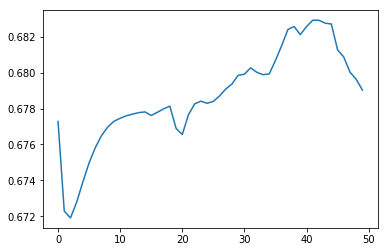

In [8]:
plt.plot(loss_)

In [9]:
d1 = data
d1['pred'] = np.argmax(res, 1)
d1['admit'] = np.argmax(d1.iloc[:,[7,8]].to_numpy(), 1)
d1['res_0'] = res[:,[0]]
d1['res_1'] = res[:,[1]]
d1

,gre,gpa,rank,rank_1,rank_2,rank_3,rank_4,admit_0,admit_1,pred,admit,res_0,res_1
0,380,3.61,3,0,0,1,0,1,0,0,0,0.793298,0.222037
1,660,3.67,3,0,0,1,0,0,1,0,1,0.730335,0.288630
2,800,4.00,1,1,0,0,0,0,1,1,1,0.436657,0.577450
3,640,3.19,4,0,0,0,1,0,1,0,1,0.825534,0.210077
4,520,2.93,4,0,0,0,1,1,0,0,0,0.846794,0.189339
...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,620,4.00,2,0,1,0,0,1,0,0,0,0.614784,0.346188
396,560,3.04,3,0,0,1,0,1,0,0,0,0.765271,0.249852
397,460,2.63,2,0,1,0,0,1,0,0,0,0.677784,0.289957
398,700,3.65,2,0,1,0,0,1,0,0,0,0.609266,0.350634


In [10]:
np.bincount(np.equal(np.argmax(res, 1), np.argmax(d1.iloc[:,[7,8]].to_numpy(), 1)))

array([117, 283], dtype=int64)